In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 1: Import Libraries

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate,
    Blur, ElasticTransform, RandomBrightnessContrast, GaussNoise
)
from albumentations.pytorch import ToTensorV2
from tensorflow.keras.utils import plot_model


# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


Loaded 900 training images.
Loaded 900 training masks.
Loaded 379 test images.
Loaded 379 test masks.


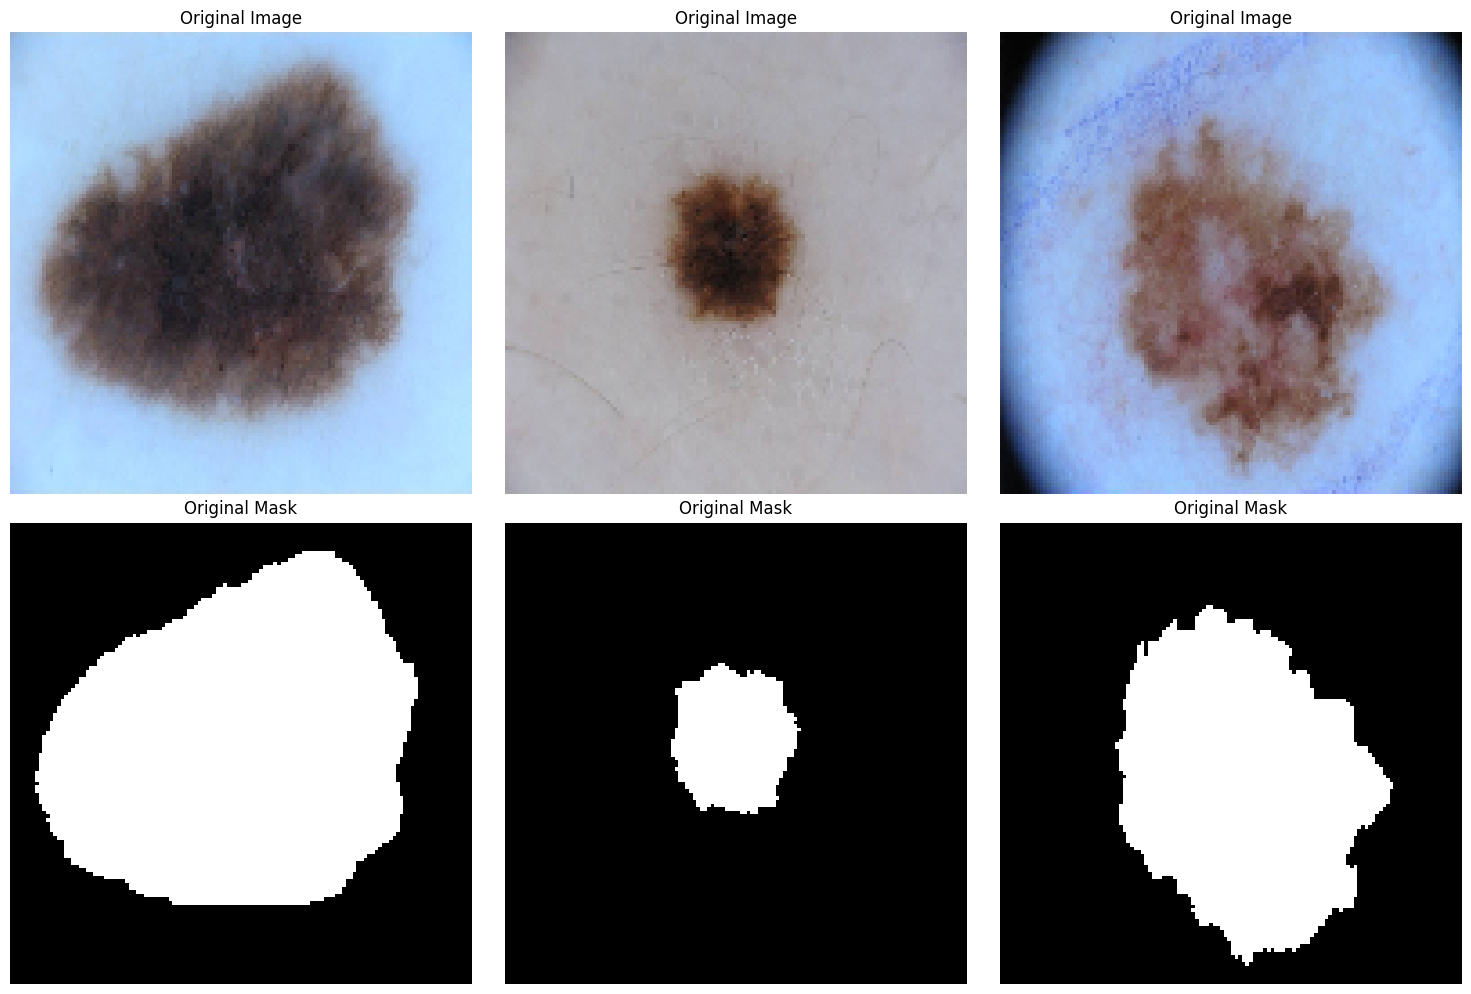

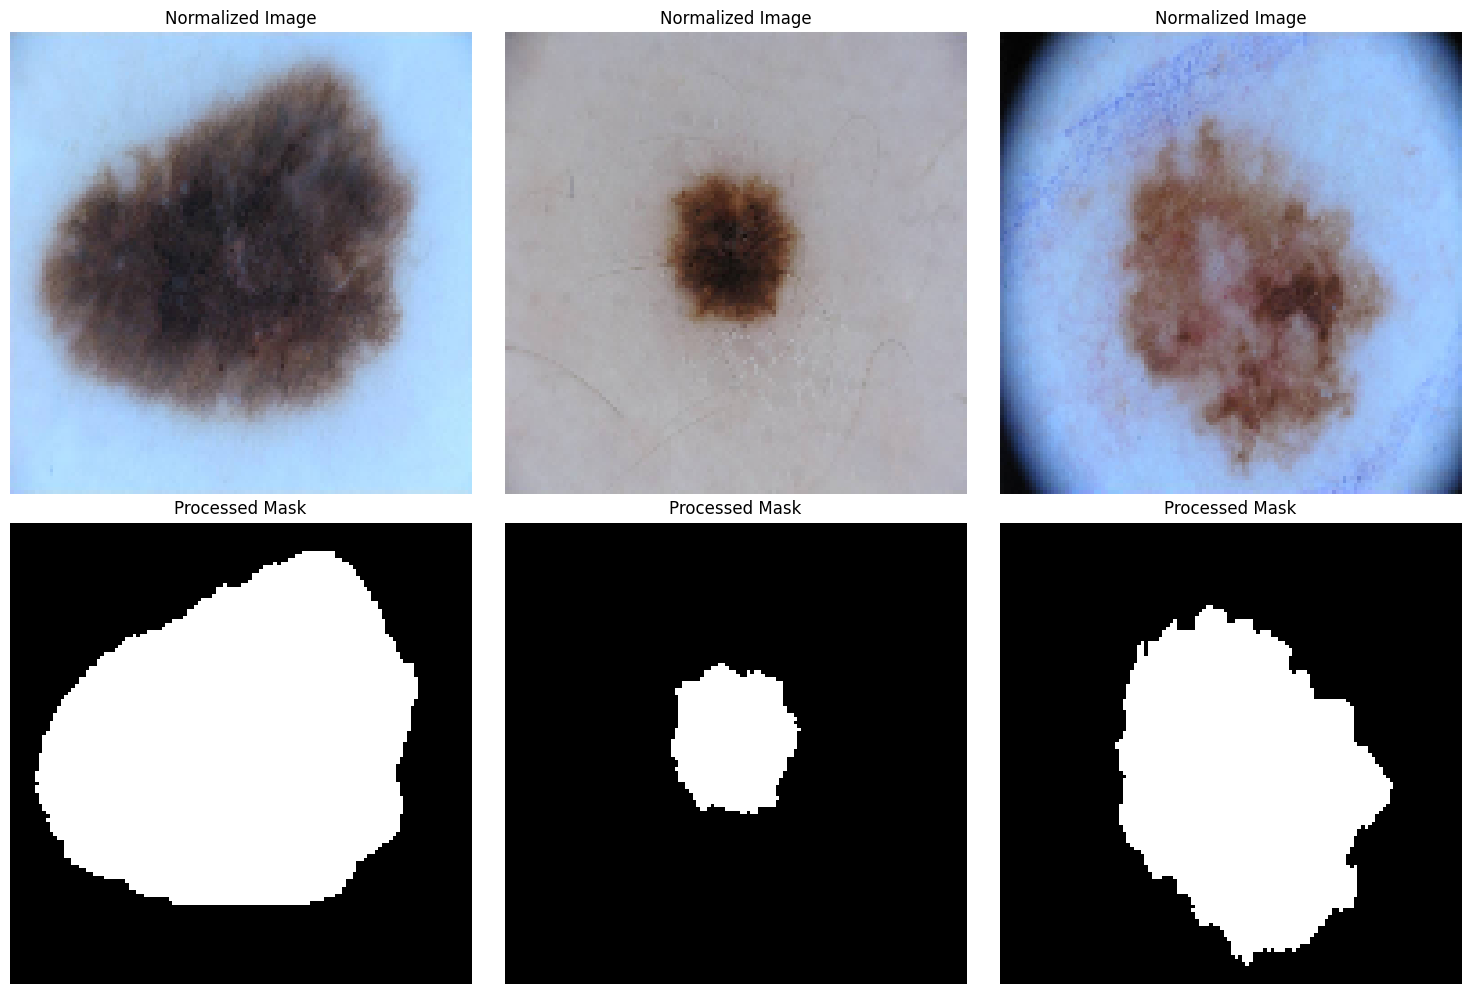

Training samples: (720, 128, 128, 3)
Validation samples: (180, 128, 128, 3)
Test samples: (379, 128, 128, 3)


In [ ]:
# Cell 2: Data Loading and Preprocessing

def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img)
    return np.array(images)

def load_masks_from_folder(folder, img_size=(128, 128)):
    masks = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        mask_path = os.path.join(folder, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
            # Binarize the mask
            _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
            masks.append(mask)
    return np.array(masks)

def preprocess_data():
    # Define paths (Replace with your actual paths)
    base_dir = '/content/drive/MyDrive/health_care_project/extracted_files' # Update this path
    train_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Training_Data')
    train_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Training_GroundTruth')
    test_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_Data')
    test_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_GroundTruth')  # Replace with actual path

    # Load images and masks
    train_images = load_images_from_folder(train_images_dir)
    train_masks = load_masks_from_folder(train_masks_dir)
    test_images = load_images_from_folder(test_images_dir)
    test_masks = load_masks_from_folder(test_masks_dir)

    print(f"Loaded {len(train_images)} training images.")
    print(f"Loaded {len(train_masks)} training masks.")
    print(f"Loaded {len(test_images)} test images.")
    print(f"Loaded {len(test_masks)} test masks.")

    # Visualization Before Preprocessing
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    for i in range(3):
        axs[0, i].imshow(train_images[i])
        axs[0, i].set_title('Original Image')
        axs[0, i].axis('off')
        axs[1, i].imshow(train_masks[i].squeeze(), cmap='gray')
        axs[1, i].set_title('Original Mask')
        axs[1, i].axis('off')
    plt.tight_layout()
    plt.show()

    # Normalize images
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Expand dimensions for masks
    train_masks = np.expand_dims(train_masks, axis=-1)
    test_masks = np.expand_dims(test_masks, axis=-1)

    # Visualization After Preprocessing
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    for i in range(3):
        axs[0, i].imshow(train_images[i])
        axs[0, i].set_title('Normalized Image')
        axs[0, i].axis('off')
        axs[1, i].imshow(train_masks[i].squeeze(), cmap='gray')
        axs[1, i].set_title('Processed Mask')
        axs[1, i].axis('off')
    plt.tight_layout()
    plt.show()

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        train_images, train_masks, test_size=0.2, random_state=42
    )

    print(f"Training samples: {X_train.shape}")
    print(f"Validation samples: {X_val.shape}")
    print(f"Test samples: {test_images.shape}")

    return X_train, X_val, y_train, y_val, test_images, test_masks

# Execute preprocessing
X_train, X_val, y_train, y_val, test_images, test_masks = preprocess_data()


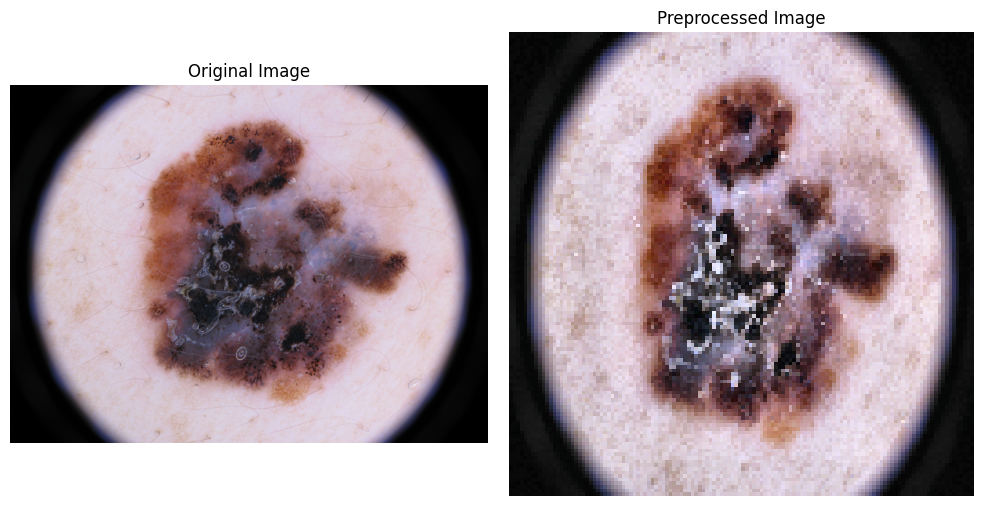

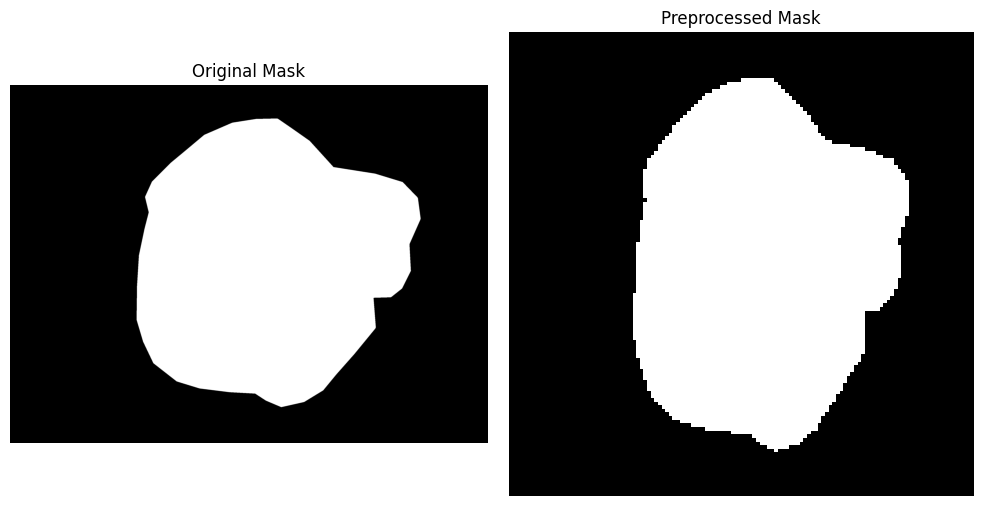

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_image(image, target_size=(128, 128)):
    """
    Preprocess a single image by applying hair removal, contrast enhancement,
    and resizing to a target size.
    """
    # Step 1: Convert to Grayscale for Hair Removal
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Step 2: Apply Morphological Operations to Detect Hair
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Step 3: Inpaint to Remove Hair
    _, binary_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    inpainted_image = cv2.inpaint(image, binary_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

    # Step 4: Contrast Enhancement (CLAHE)
    lab = cv2.cvtColor(inpainted_image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge((l, a, b))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    # Step 5: Resize Image
    resized_image = cv2.resize(enhanced_image, target_size)

    # Step 6: Normalize Pixel Values to [0, 1]
    normalized_image = resized_image / 255.0

    return normalized_image


def preprocess_dataset(image_folder, target_size=(128, 128)):
    """
    Preprocess all images in a folder and return them as a NumPy array.
    """
    images = []
    filenames = sorted(os.listdir(image_folder))
    for filename in filenames:
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            preprocessed_img = preprocess_image(img, target_size=target_size)
            images.append(preprocessed_img)
    return np.array(images)

# Example: Visualizing Preprocessing
sample_image_path = '/content/drive/MyDrive/health_care_project/extracted_files/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000140.jpg'
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

preprocessed_sample = preprocess_image(sample_image)

# Visualize Original and Preprocessed Image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_sample)
plt.title('Preprocessed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_mask(mask, target_size=(128, 128)):
    """
    Preprocess a single binary mask:
    1. Resize the mask to the target size.
    2. Binarize the mask to ensure values are 0 or 1.
    3. Add a channel axis for compatibility with deep learning models.
    """
    # Step 1: Resize Mask
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

    # Step 2: Binarize the Mask
    _, binarized_mask = cv2.threshold(resized_mask, 127, 1, cv2.THRESH_BINARY)

    # Step 3: Add a Channel Axis
    binarized_mask = np.expand_dims(binarized_mask, axis=-1)

    return binarized_mask


# Example Usage: Visualize Preprocessed Mask
mask_path = '/content/drive/MyDrive/health_care_project/extracted_files/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000140_Segmentation.png'  # Path to the provided mask
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the mask
preprocessed_mask = preprocess_mask(mask, target_size=(128, 128))

# Visualize Original and Preprocessed Mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_mask.squeeze(), cmap='gray')
plt.title('Preprocessed Mask')
plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

def preprocess_image(image, target_size=(128, 128)):
    """
    Preprocess a single image by applying hair removal, contrast enhancement,
    and resizing to a target size.
    """
    # Step 1: Convert to Grayscale for Hair Removal
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Step 2: Apply Morphological Operations to Detect Hair
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Step 3: Inpaint to Remove Hair
    _, binary_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    inpainted_image = cv2.inpaint(image, binary_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

    # Step 4: Contrast Enhancement (CLAHE)
    lab = cv2.cvtColor(inpainted_image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge((l, a, b))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    # Step 5: Resize Image
    resized_image = cv2.resize(enhanced_image, target_size)

    # Step 6: Normalize Pixel Values to [0, 1]
    normalized_image = resized_image / 255.0

    return normalized_image


def preprocess_mask(mask, target_size=(128, 128)):
    """
    Preprocess a single binary mask:
    1. Resize the mask to the target size.
    2. Binarize the mask to ensure values are 0 or 1.
    3. Add a channel axis for compatibility with deep learning models.
    """
    # Step 1: Resize Mask
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

    # Step 2: Binarize the Mask
    _, binarized_mask = cv2.threshold(resized_mask, 127, 1, cv2.THRESH_BINARY)

    # Step 3: Add a Channel Axis
    binarized_mask = np.expand_dims(binarized_mask, axis=-1)

    return binarized_mask


def visualize_multiple_images(base_image_path, base_mask_path, count=7, target_size=(128, 128)):
    """
    Visualize a sequence of images and masks along with their preprocessed counterparts.
    The filenames increment by 1 in the numeric part.

    Parameters:
    - base_image_path: Path to the base image file (before increment).
    - base_mask_path: Path to the base mask file (before increment).
    - count: Number of images to visualize.
    - target_size: Target size for preprocessing.
    """
    base_dir_image = os.path.dirname(base_image_path)
    base_dir_mask = os.path.dirname(base_mask_path)

    # Extract base names and formats
    image_base = os.path.basename(base_image_path).split('_')[0]
    mask_base = os.path.basename(base_mask_path).split('_')[0]
    image_ext = base_image_path.split('.')[-1]
    mask_ext = base_mask_path.split('.')[-1]

    # Extract the numeric part with error handling
    try:
        image_number_str = os.path.basename(base_image_path).split('_')[-1].split('.')[0]
        image_start_number = int(image_number_str)
    except ValueError:
        print(f"Error: Cannot extract numeric part from image filename: {base_image_path}")
        return

    try:
        # Corrected extraction for mask number
        mask_number_str = os.path.basename(base_mask_path).split('_')[1]
        mask_start_number = int(mask_number_str)
    except (IndexError, ValueError):
        print(f"Error: Cannot extract numeric part from mask filename: {base_mask_path}")
        return

    for i in range(count):
        image_number = image_start_number + i
        mask_number = mask_start_number + i

        # Format numbers with leading zeros to maintain filename consistency
        image_number_formatted = str(image_number).zfill(7)  # Assuming 7 digits
        mask_number_formatted = str(mask_number).zfill(7)    # Adjust zfill based on your naming

        image_name = f"{image_base}_{image_number_formatted}.{image_ext}"
        mask_name = f"{mask_base}_{mask_number_formatted}_Segmentation.{mask_ext}"

        image_path = os.path.join(base_dir_image, image_name)
        mask_path = os.path.join(base_dir_mask, mask_name)

        if not os.path.exists(image_path):
            print(f"File not found: {image_path}. Skipping...")
            continue
        if not os.path.exists(mask_path):
            print(f"File not found: {mask_path}. Skipping...")
            continue

        # Load and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}. Skipping...")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        preprocessed_image = preprocess_image(image, target_size)

        # Load and preprocess the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Error reading mask: {mask_path}. Skipping...")
            continue
        preprocessed_mask = preprocess_mask(mask, target_size)

        # Visualization
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.imshow(image)
        plt.title(f'Original Image: {image_name}')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(preprocessed_image)
        plt.title('Preprocessed Image')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Original Mask: {mask_name}')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(preprocessed_mask.squeeze(), cmap='gray')
        plt.title('Preprocessed Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Clear variables and collect garbage to free memory
        del image, mask, preprocessed_image, preprocessed_mask
        gc.collect()


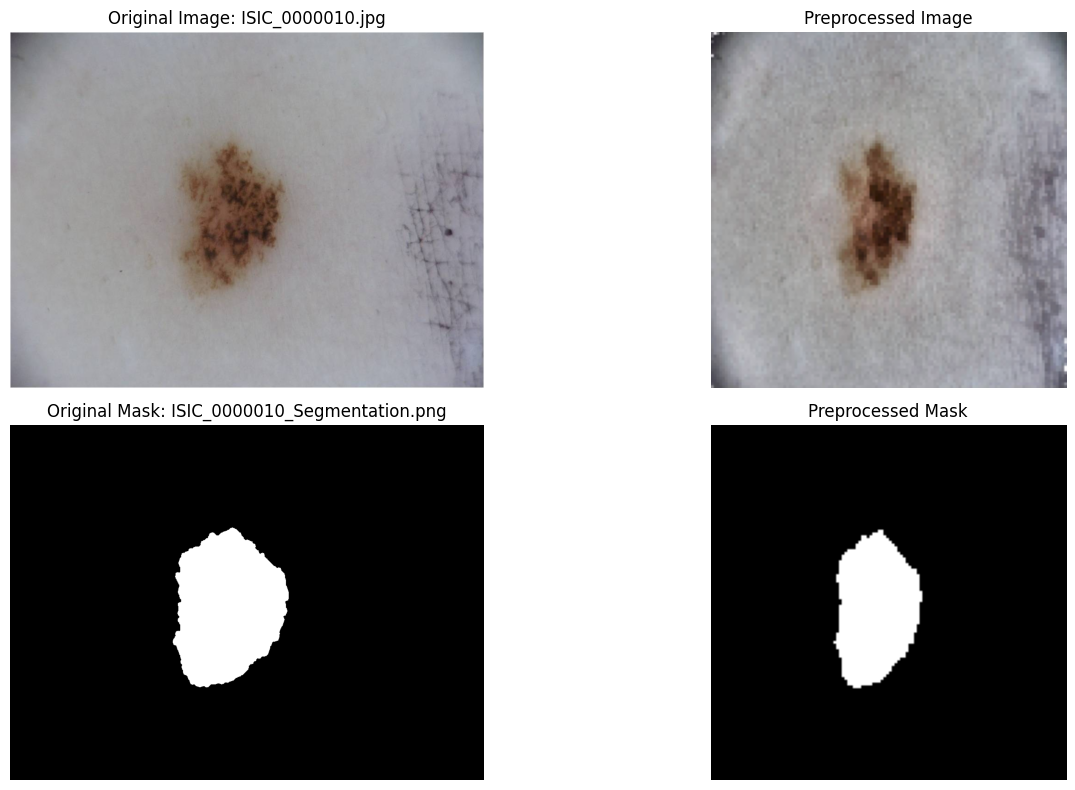

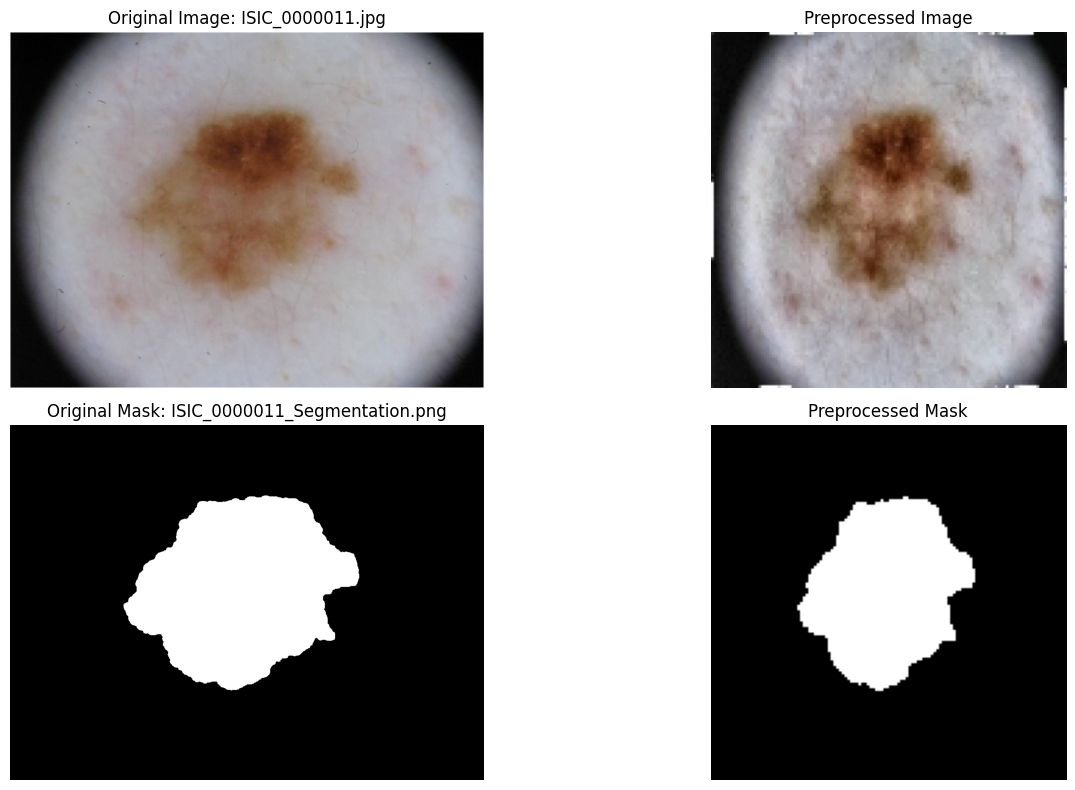

File not found: /content/drive/MyDrive/health_care_project/extracted_files/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000012.jpg. Skipping...
File not found: /content/drive/MyDrive/health_care_project/extracted_files/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000013.jpg. Skipping...
File not found: /content/drive/MyDrive/health_care_project/extracted_files/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000014.jpg. Skipping...
File not found: /content/drive/MyDrive/health_care_project/extracted_files/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000015.jpg. Skipping...


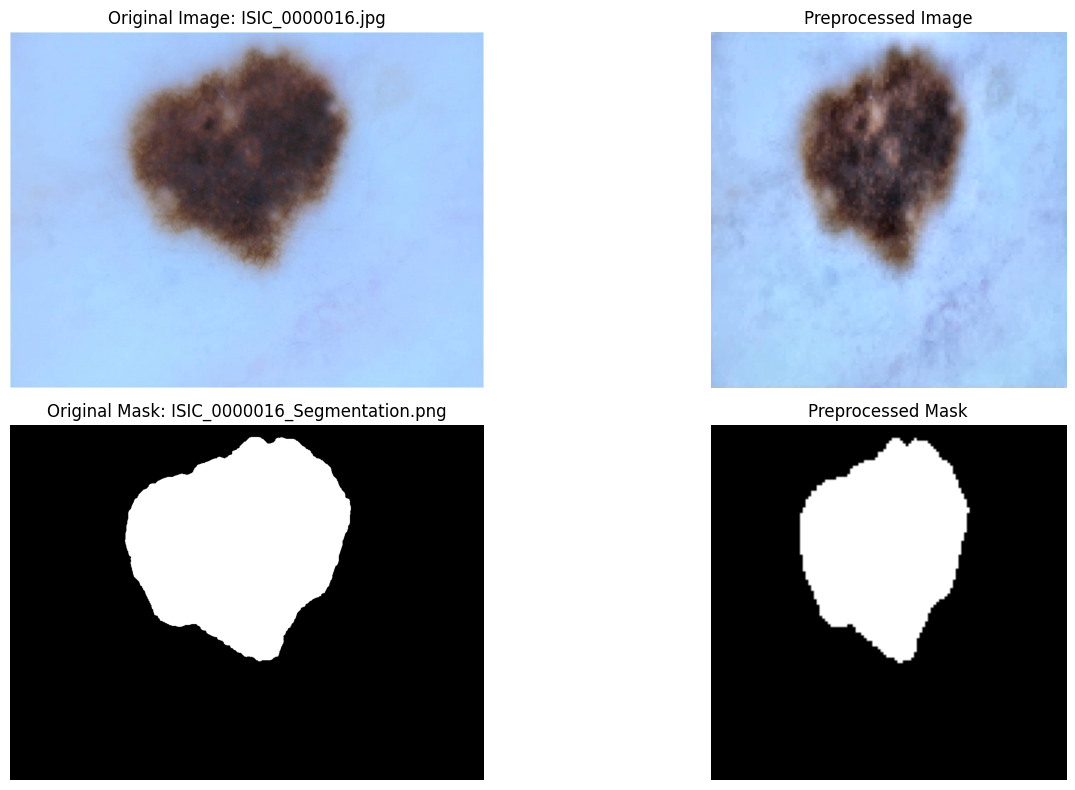

In [ ]:
# Example usage
base_image_path = '/content/drive/MyDrive/health_care_project/extracted_files/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000010.jpg'
base_mask_path = '/content/drive/MyDrive/health_care_project/extracted_files/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000010_Segmentation.png'

visualize_multiple_images(base_image_path, base_mask_path, count=7, target_size=(128, 128))


In [ ]:
# Cell 3: Data Augmentation with Albumentations

import albumentations as A
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate, Blur, ElasticTransform, RandomBrightnessContrast, GaussNoise

def get_training_augmentation():
    train_transform = Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Rotate(limit=15, p=0.5),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        Blur(blur_limit=3, p=0.2),
    ])
    return train_transform

def get_validation_augmentation():
    valid_transform = Compose([
        # Typically, only normalization or minimal transformations
    ])
    return valid_transform

def augment_data_albumentations(X_train, y_train, X_val, y_val, train_transform, valid_transform, batch_size=16):
    # Define generator using Albumentations
    def generator(images, masks, transform, batch_size):
        while True:
            indices = np.arange(len(images))
            np.random.shuffle(indices)
            for i in range(0, len(images), batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_images = images[batch_indices]
                batch_masks = masks[batch_indices]
                augmented_images = []
                augmented_masks = []
                for img, mask in zip(batch_images, batch_masks):
                    augmented = transform(image=(img * 255).astype(np.uint8), mask=(mask.squeeze() * 255).astype(np.uint8))
                    augmented_images.append(augmented['image'] / 255.0)
                    augmented_masks.append(np.expand_dims(augmented['mask'] / 255.0, axis=2))
                yield np.array(augmented_images), np.array(augmented_masks)

    train_gen = generator(X_train, y_train, train_transform, batch_size)
    val_gen = generator(X_val, y_val, valid_transform, batch_size)

    return train_gen, val_gen

# Define augmentations
train_transform = get_training_augmentation()
valid_transform = get_validation_augmentation()

# Get generators
BATCH_SIZE = 16
train_gen, val_gen = augment_data_albumentations(X_train, y_train, X_val, y_val, train_transform, valid_transform, BATCH_SIZE)


In [ ]:
# Cell 4: Model Definitions: U-Net, U-Net++, ResUNet

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    x = layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    x = layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    return x

def encoder_block(inputs, filters, pool=True):
    x = conv_block(inputs, filters)
    if pool:
        p = layers.MaxPooling2D((2, 2))(x)
        return x, p
    else:
        return x

def decoder_block(inputs, skip_features, filters, kernel_size=3, activation='relu', padding='same'):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding=padding)(inputs)
    x = layers.concatenate([x, skip_features])
    x = conv_block(x, filters, kernel_size, activation, padding)
    return x

def build_unet(input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs, outputs, name='U-Net')
    return model

def build_unetpp(input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)    # s1: (128,128,64)
    s2, p2 = encoder_block(p1, 128)       # s2: (64,64,128)
    s3, p3 = encoder_block(p2, 256)       # s3: (32,32,256)
    s4, p4 = encoder_block(p3, 512)       # s4: (16,16,512)

    # Bridge
    b1 = conv_block(p4, 1024)              # b1: (16,16,1024)

    # Decoder Path 1
    d1 = decoder_block(b1, s4, 512)        # d1: (16,16,512)

    # Upsample d1 to match s3's spatial dimensions
    d1_up = layers.UpSampling2D((2, 2), interpolation='bilinear')(d1)  # d1_up: (32,32,512)
    d2 = layers.concatenate([d1_up, s3], axis=-1)                       # d2: (32,32,512+256=768)
    d2 = conv_block(d2, 256)                                           # d2: (32,32,256)

    # Upsample d2 to match s2's spatial dimensions
    d2_up = layers.UpSampling2D((2, 2), interpolation='bilinear')(d2)  # d2_up: (64,64,256)
    d3 = layers.concatenate([d2_up, s2], axis=-1)                       # d3: (64,64,256+128=384)
    d3 = conv_block(d3, 128)                                           # d3: (64,64,128)

    # Upsample d3 to match s1's spatial dimensions
    d3_up = layers.UpSampling2D((2, 2), interpolation='bilinear')(d3)  # d3_up: (128,128,128)
    d4 = layers.concatenate([d3_up, s1], axis=-1)                       # d4: (128,128,128+64=192)
    d4 = conv_block(d4, 64)                                            # d4: (128,128,64)

    # Output Layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)  # outputs: (128,128,1)

    model = models.Model(inputs, outputs, name='U-Net++')
    return model


def build_resunet(input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(input_shape)

    # Encoder with Residual Connections
    def res_encoder_block(inputs, filters):
        x = layers.Conv2D(filters, (3,3), padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        shortcut = layers.Conv2D(filters, (1,1), padding='same')(inputs)
        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        p = layers.MaxPooling2D((2,2))(x)
        return x, p

    # Decoder with Residual Connections
    def res_decoder_block(inputs, skip_features, filters):
        x = layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding='same')(inputs)
        x = layers.concatenate([x, skip_features])
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        shortcut = layers.Conv2D(filters, (1,1), padding='same')(x)
        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    # Encoder
    s1, p1 = res_encoder_block(inputs, 64)
    s2, p2 = res_encoder_block(p1, 128)
    s3, p3 = res_encoder_block(p2, 256)
    s4, p4 = res_encoder_block(p3, 512)

    # Bridge
    b1 = layers.Conv2D(1024, (3,3), padding='same')(p4)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b1 = layers.Conv2D(1024, (3,3), padding='same')(b1)
    b1 = layers.BatchNormalization()(b1)
    shortcut = layers.Conv2D(1024, (1,1), padding='same')(p4)
    b1 = layers.add([b1, shortcut])
    b1 = layers.Activation('relu')(b1)

    # Decoder
    d1 = res_decoder_block(b1, s4, 512)
    d2 = res_decoder_block(d1, s3, 256)
    d3 = res_decoder_block(d2, s2, 128)
    d4 = res_decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs, outputs, name='ResUNet')
    return model

# Instantiate models
unet = build_unet()
unetpp = build_unetpp()
resunet = build_resunet()

# Display model summaries
print("U-Net Model Summary:")
unet.summary()

print("\nU-Net++ Model Summary:")
unetpp.summary()

print("\nResUNet Model Summary:")
resunet.summary()


U-Net Model Summary:


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 64, 64, 64)     │              0 │ conv2d_32[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 32, 32, 128)    │              0 │ conv2d_34[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 16, 16, 256)    │              0 │ conv2d_36[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_37[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 8, 8, 512)      │              0 │ conv2d_38[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_39[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_40[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6        

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)


U-Net++ Model Summary:


Model: "U-Net++"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 64, 64, 64)     │              0 │ conv2d_51[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 32, 32, 128)    │              0 │ conv2d_53[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_54[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 16, 16, 256)    │              0 │ conv2d_55[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 8, 8, 512)      │              0 │ conv2d_57[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_9        │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_59[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10       

 Total params: 31,117,313 (118.70 MB)

 Trainable params: 31,117,313 (118.70 MB)

 Non-trainable params: 0 (0.00 B)


ResUNet Model Summary:


Model: "ResUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d_69[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_70[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 128, 128, 64)   │            256 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│                           │                        │                │ conv2d_71[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_73[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 64, 64, 128)    │          8,320 │ max_pooling2d_16[0][0] │
├──────────────────────

 Total params: 32,102,913 (122.46 MB)

 Trainable params: 32,091,137 (122.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
# Cell 5: Setting Up Mixed Precision

from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

print("Mixed precision enabled. Current policy:", mixed_precision.global_policy())


Mixed precision enabled. Current policy: <DTypePolicy "mixed_float16">


In [ ]:
# Cell 6: Model Compilation and Training

import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Computes the Dice Coefficient.
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred)


from tensorflow.keras import optimizers

def compile_model(model):
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss=bce_dice_loss,  # Ensure this loss function is updated similarly
        metrics=['accuracy', dice_coefficient, MeanIoU(num_classes=2)]
    )
    return model




In [ ]:
# Cell 6: Training U-Net

# Ensure that the 'models/' directory exists
os.makedirs('models', exist_ok=True)

# Compile the U-Net model
unet = build_unet()  # Assuming build_unet() is defined in Cell 4
unet = compile_model(unet)  # Assuming compile_model() is defined in Cell 6 (previously)

# Define callbacks specific to U-Net
checkpoint_unet = ModelCheckpoint(
    'models/unet_best.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
early_stop_unet = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True
)
callbacks_unet = [checkpoint_unet, early_stop_unet]

# Calculate steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

# Train the U-Net model
history_unet = unet.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=callbacks_unet
)

# Save the final U-Net model
unet.save('models/unet_final.keras')
print("U-Net training completed and model saved as 'unet_final.h5'.")


Epoch 1/100


TypeError: Input 'y' of 'Mul' Op has type float16 that does not match type float64 of argument 'x'.

In [ ]:
# Cell 7: Training U-Net++

# Compile the U-Net++ model
unetpp = build_unetpp()  # Assuming build_unetpp() is defined in Cell 4
unetpp = compile_model(unetpp)  # Using the same compile_model function

# Define callbacks specific to U-Net++
checkpoint_unetpp = ModelCheckpoint(
    'models/unetpp_best.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
early_stop_unetpp = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True
)
callbacks_unetpp = [checkpoint_unetpp, early_stop_unetpp]

# Train the U-Net++ model
history_unetpp = unetpp.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=callbacks_unetpp
)

# Save the final U-Net++ model
unetpp.save('models/unetpp_final.h5')
print("U-Net++ training completed and model saved as 'unetpp_final.h5'.")


In [ ]:
# Cell 9: Demonstrating Real-World Medical Impact

# Example: Visualizing Predictions and Masks

def visualize_prediction(model, image, mask, threshold=0.5, model_name='Model'):
    # Predict
    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    prediction = (prediction > threshold).astype(np.uint8).squeeze()

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[1].axis('off')

    axs[2].imshow(prediction, cmap='gray')
    axs[2].set_title(f'{model_name} Prediction')
    axs[2].axis('off')

    plt.show()

# Select a sample from test set
sample_idx = 1
sample_image = test_images[sample_idx]
sample_mask = test_masks[sample_idx]

# Visualize U-Net prediction
print("U-Net Prediction:")
visualize_prediction(unet_best, sample_image, sample_mask, model_name='U-Net')

# Visualize U-Net++ prediction
print("U-Net++ Prediction:")
visualize_prediction(unetpp_best, sample_image, sample_mask, model_name='U-Net++')

# Visualize ResUNet prediction
print("ResUNet Prediction:")
visualize_prediction(resunet_best, sample_image, sample_mask, model_name='ResUNet')


In [ ]:
# Cell 8: Training ResUNet

# Compile the ResUNet model
resunet = build_resunet()  # Assuming build_resunet() is defined in Cell 4
resunet = compile_model(resunet)  # Using the same compile_model function

# Define callbacks specific to ResUNet
checkpoint_resunet = ModelCheckpoint(
    'models/resunet_best.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
early_stop_resunet = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True
)
callbacks_resunet = [checkpoint_resunet, early_stop_resunet]

# Train the ResUNet model
history_resunet = resunet.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=callbacks_resunet
)

# Save the final ResUNet model
resunet.save('models/resunet_final.h5')
print("ResUNet training completed and model saved as 'resunet_final.h5'.")


In [ ]:
# Cell 7: Model Evaluation

from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, threshold=0.5, model_name='Model'):
    # Predict on test data
    predictions = model.predict(X_test, batch_size=BATCH_SIZE)
    predictions = (predictions > threshold).astype(np.uint8)

    # Flatten the arrays
    y_true = y_test.flatten()
    y_pred = predictions.flatten()

    # Classification Report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=['Background', 'Lesion']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, classes=['Background', 'Lesion'], title=f'{model_name} Confusion Matrix')

    # Calculate additional metrics
    dice = dice_coefficient_tf(y_test, predictions).numpy()
    iou = MeanIoU(num_classes=2)(y_test, predictions).numpy()
    print(f"{model_name} Dice Coefficient: {dice:.4f}")
    print(f"{model_name} Mean IoU: {iou:.4f}")

def dice_coefficient_tf(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Load the best models
unet_best = build_unet()
unet_best.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=['accuracy', dice_coefficient, MeanIoU(num_classes=2)]
)
unet_best.load_weights('models/unet_best.h5')

unetpp_best = build_unetpp()
unetpp_best.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=['accuracy', dice_coefficient, MeanIoU(num_classes=2)]
)
unetpp_best.load_weights('models/unetpp_best.h5')

resunet_best = build_resunet()
resunet_best.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=['accuracy', dice_coefficient, MeanIoU(num_classes=2)]
)
resunet_best.load_weights('models/resunet_best.h5')

# Evaluate U-Net
print("Evaluating U-Net...")
evaluate_model(unet_best, test_images, test_masks, model_name='U-Net')

# Evaluate U-Net++
print("Evaluating U-Net++...")
evaluate_model(unetpp_best, test_images, test_masks, model_name='U-Net++')

# Evaluate ResUNet
print("Evaluating ResUNet...")
evaluate_model(resunet_best, test_images, test_masks, model_name='ResUNet')


In [ ]:
# Cell 8: Visualization of Predictions

def visualize_prediction(model, image, mask, threshold=0.5, model_name='Model'):
    # Predict
    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    prediction = (prediction > threshold).astype(np.uint8).squeeze()

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[1].axis('off')

    axs[2].imshow(prediction, cmap='gray')
    axs[2].set_title(f'{model_name} Prediction')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# Select a subset of test samples to visualize
num_samples = 5
sample_indices = np.random.choice(len(test_images), num_samples, replace=False)

for idx in sample_indices:
    sample_image = test_images[idx]
    sample_mask = test_masks[idx]

    print(f"Sample Index: {idx}")

    # U-Net Prediction
    visualize_prediction(unet_best, sample_image, sample_mask, model_name='U-Net')

    # U-Net++ Prediction
    visualize_prediction(unetpp_best, sample_image, sample_mask, model_name='U-Net++')

    # ResUNet Prediction
    visualize_prediction(resunet_best, sample_image, sample_mask, model_name='ResUNet')

    print("\n" + "-"*50 + "\n")


In [ ]:
# Cell 9: Saving Models

# Models have already been saved during training in the 'models/' directory.
# Additionally, save the final models here if needed.

unet_best.save('models/unet_best_final.h5')
unetpp_best.save('models/unetpp_best_final.h5')
resunet_best.save('models/resunet_best_final.h5')

print("All models have been saved successfully.")
